In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/System-Threat-Forecaster/sample_submission.csv
/kaggle/input/System-Threat-Forecaster/train.csv
/kaggle/input/System-Threat-Forecaster/test.csv


# 📌 All Necessary Imports  

This section imports all essential **libraries and modules** required for **data preprocessing, feature selection, model training, and evaluation** 🚀.  

### 🔹 **General Utilities**
- `time`, `warnings` → Handles execution time and suppresses unnecessary warnings.  
- `numpy`, `pandas` → Core libraries for numerical operations and data handling.  

### 🔹 **Data Visualization**
- `seaborn`, `matplotlib.pyplot` → Used for plotting **graphs and charts** 📊.  

### 🔹 **Preprocessing & Feature Engineering**
- `SimpleImputer`, `Pipeline`, `ColumnTransformer` → Handles **missing values** and **feature transformation**.  
- `MinMaxScaler`, `OneHotEncoder`, `StandardScaler`, `RobustScaler` → Scales and encodes features.  

### 🔹 **Model Selection & Evaluation**
- `train_test_split`, `GridSearchCV`, `cross_val_score` → Splits data and **performs hyperparameter tuning** 🔍.  
- `SelectKBest`, `mutual_info_classif` → Selects the **most important features**.  
- `classification_report`, `accuracy_score`, `confusion_matrix` → Evaluates **model performance** 📈.  

### 🔹 **Machine Learning Models**
- **Linear Models**: `LogisticRegression`, `RidgeClassifier`  
- **Tree-Based Models**: `RandomForestClassifier`, `GradientBoostingClassifier`  
- **Boosting Models**: `XGBClassifier` (XGBoost), `LGBMClassifier` (LightGBM), `CatBoostClassifier` (CatBoost)  

🔹 **Finally, warnings are suppressed** to keep the output clean. 🚀  


In [2]:
import time
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Suppress warnings
warnings.filterwarnings("ignore")

# Data Loading and Exploration

In this section, we will load the dataset using Pandas and perform initial exploration to understand its structure.
The dataset is stored in Kaggle's `/kaggle/input/` directory. We will first load the `train.csv` and `test.csv` files and inspect their content.


In [3]:
# Load the dataset
df = "/kaggle/input/System-Threat-Forecaster/train.csv"
test_path = "/kaggle/input/System-Threat-Forecaster/test.csv"

df = pd.read_csv(df)
test = pd.read_csv(test_path)

In [4]:
df.columns

Index(['MachineID', 'ProductName', 'EngineVersion', 'AppVersion',
       'SignatureVersion', 'IsBetaUser', 'RealTimeProtectionState',
       'IsPassiveModeEnabled', 'AntivirusConfigID',
       'NumAntivirusProductsInstalled', 'NumAntivirusProductsEnabled',
       'HasTpm', 'CountryID', 'CityID', 'GeoRegionID', 'LocaleEnglishNameID',
       'PlatformType', 'Processor', 'OSVersion', 'OSBuildNumber',
       'OSProductSuite', 'OsPlatformSubRelease', 'OSBuildLab',
       'SKUEditionName', 'IsSystemProtected', 'AutoSampleSubmissionEnabled',
       'SMode', 'IEVersionID', 'FirewallEnabled', 'EnableLUA',
       'MDC2FormFactor', 'DeviceFamily', 'OEMNameID', 'OEMModelID',
       'ProcessorCoreCount', 'ProcessorManufacturerID', 'ProcessorModelID',
       'PrimaryDiskCapacityMB', 'PrimaryDiskType', 'SystemVolumeCapacityMB',
       'HasOpticalDiskDrive', 'TotalPhysicalRAMMB', 'ChassisType',
       'PrimaryDisplayDiagonalInches', 'PrimaryDisplayResolutionHorizontal',
       'PrimaryDisplayResolutio

In [5]:
test.shape

(10000, 75)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 76 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   MachineID                           100000 non-null  object 
 1   ProductName                         100000 non-null  object 
 2   EngineVersion                       100000 non-null  object 
 3   AppVersion                          100000 non-null  object 
 4   SignatureVersion                    100000 non-null  object 
 5   IsBetaUser                          100000 non-null  int64  
 6   RealTimeProtectionState             99934 non-null   float64
 7   IsPassiveModeEnabled                100000 non-null  int64  
 8   AntivirusConfigID                   99924 non-null   float64
 9   NumAntivirusProductsInstalled       99924 non-null   float64
 10  NumAntivirusProductsEnabled         99924 non-null   float64
 11  HasTpm                     

# EDA (Exploratory Data Analysis)

First, we check the data type of each column in the dataset.  
We then store the results in a dictionary called `dtype_counts`, where:  
- **Key**: The name of the data type (e.g., Categorical, Integer, Float).  
- **Value**: The count of columns belonging to that data type in the dataset.  
This helps in understanding the overall structure of the dataset and selecting appropriate preprocessing techniques.

In [7]:
# dtype mapping 
dtype_mapping = {
    'object': 'Categorical',
    'int64': 'Integer',
    'float64': 'Float'
}

# Count the occurrences of each data type and map to descriptive names
dtype_counts = df.dtypes.replace(dtype_mapping).value_counts().to_dict()

print(dtype_counts)


{'Float': 31, 'Categorical': 28, 'Integer': 17}


## 🔢 Unique Value Count per Column  
This code calculates the **number of unique values** in each column and **sorts them in descending order** 📉.  
It helps identify **categorical features**, detect **high-cardinality columns**, and guide **feature selection** for machine learning models. 🚀  


In [8]:
uni_val= df.nunique().sort_values(ascending=False)
uni_val

MachineID                      99835
SystemVolumeCapacityMB         46188
CityID                         16047
OEMModelID                     15952
FirmwareVersionID              12299
                               ...  
IsPortableOS                       2
target                             2
IsFlightsDisabled                  1
AutoSampleSubmissionEnabled        1
IsBetaUser                         1
Length: 76, dtype: int64

## Missing Values  
This code calculates the number of missing values in each column, sorts them in descending order, and displays the top 33 columns with the highest missing values.  

In [9]:
# Missing values 
null_val = (df.isnull().sum().sort_values(ascending=False))
print(null_val.head(33))

SMode                                 981
CityID                                623
RegionIdentifier                      559
IsGamer                               559
InternalBatteryNumberOfCharges        515
FirmwareManufacturerID                376
FirmwareVersionID                     334
IsFlightsDisabled                     326
OEMModelID                            228
OEMNameID                             212
FirewallEnabled                       166
TotalPhysicalRAMMB                    151
IsAlwaysOnAlwaysConnectedCapable      134
OSInstallLanguageID                   113
PrimaryDiskCapacityMB                 110
SystemVolumeCapacityMB                110
IEVersionID                           107
ProcessorManufacturerID                85
ProcessorModelID                       85
ProcessorCoreCount                     85
IsSystemProtected                      76
NumAntivirusProductsEnabled            76
NumAntivirusProductsInstalled          76
AntivirusConfigID                 

### Outlier Detection Using IQR  
This function calculates the number of outliers in a given column using the **Interquartile Range (IQR) method**.  
It identifies values that fall **below Q1 - 1.5 * IQR** or **above Q3 + 1.5 * IQR**, helping detect potential anomalies in numerical data.  

In [10]:
# Function to count outliers using IQR method
def count_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Count values outside the IQR range, ignoring NaN values
    return ((series < lower_bound) | (series > upper_bound)).sum()

In [11]:
# Count outliers for each numerical column
# outl_counts = {col: count_outliers(df[col].dropna()) for col in num_col}
# outlier_df = pd.DataFrame(list(outl_counts.items()), columns=['Column', 'Outlier Count'])
# outlier_df = outlier_df.sort_values(by='Outlier Count', ascending=False).reset_index(drop=True)

# print(outlier_df.head(33))

## 🎯 Target Variable Distribution  

This snippet analyzes the distribution of the **target variable** 📊 by:  
✅ Counting occurrences of each class.  
✅ Calculating the **percentage distribution** of each class.  
✅ Plotting a **bar chart** 🏆 with labels showing both **count & percentage** 📉.  

This helps in detecting **class imbalance**, which is crucial for model performance! 🚀  

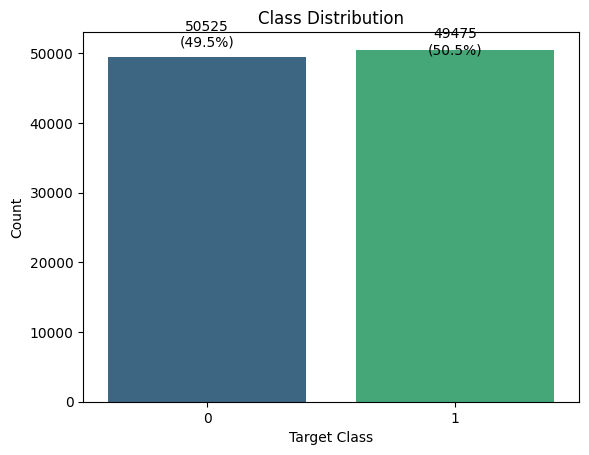

In [12]:
target_distribution = df['target'].value_counts()
percentage_distribution = df['target'].value_counts(normalize=True) * 100

# Bar plot
sns.countplot(x='target', data=df, palette='viridis')
plt.title('Class Distribution')
plt.xlabel('Target Class')
plt.ylabel('Count')

# Add annotations
for i, count in enumerate(target_distribution):
    plt.text(i, count+5, f'{count}\n({percentage_distribution[i]:.1f}%)', 
             ha='center', va='bottom')

plt.show()

### 🔍 Data Exploration: Missing & Unique Values  

📌 **Missing Values Analysis**  
- Counts missing values per column and **sorts in descending order** 📉.  
- **Bar chart** 📊 visualizes the missing data, making it easier to spot heavily affected columns.  

📌 **Unique Values Analysis**  
- Counts unique values for each column and filters out those with **less than 3 unique values**.  
- **Bar plot** 🎨 helps understand column variability, highlighting categorical and high-cardinality features.  

These insights are crucial for **handling missing data** and **feature selection** in machine learning! 🚀  

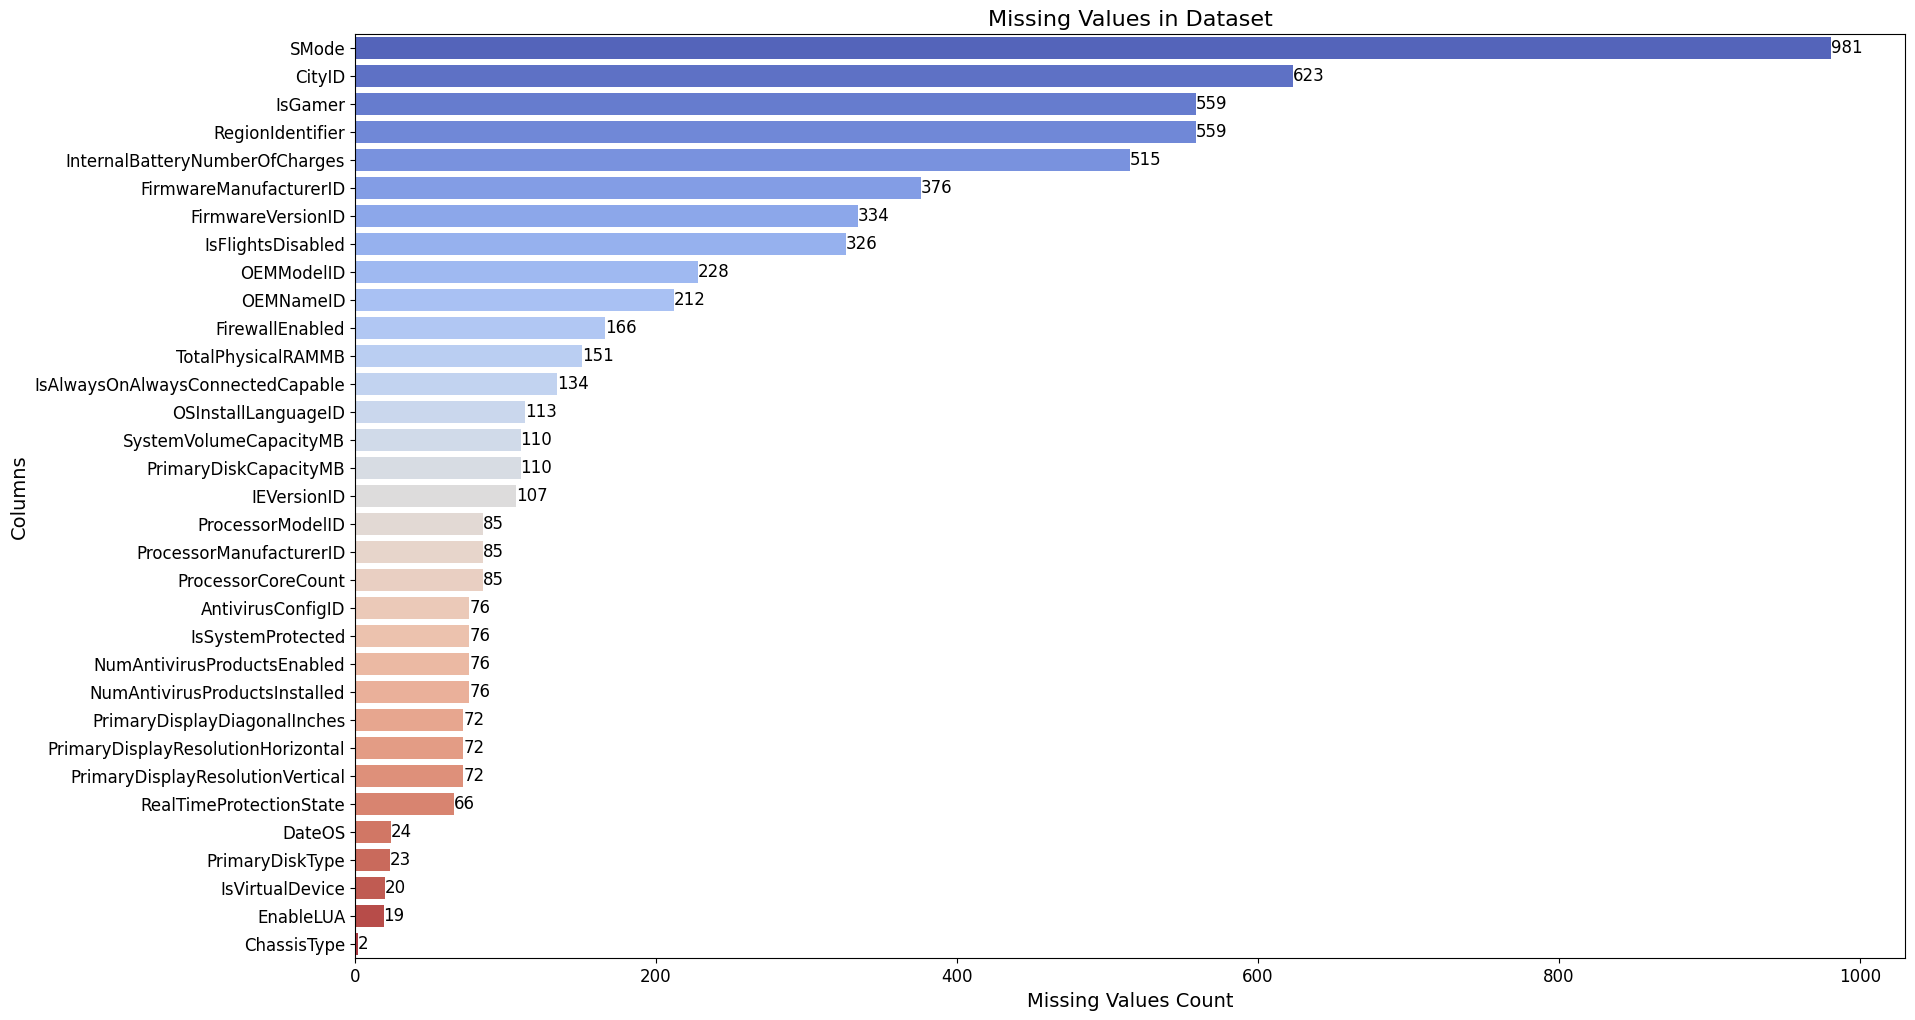

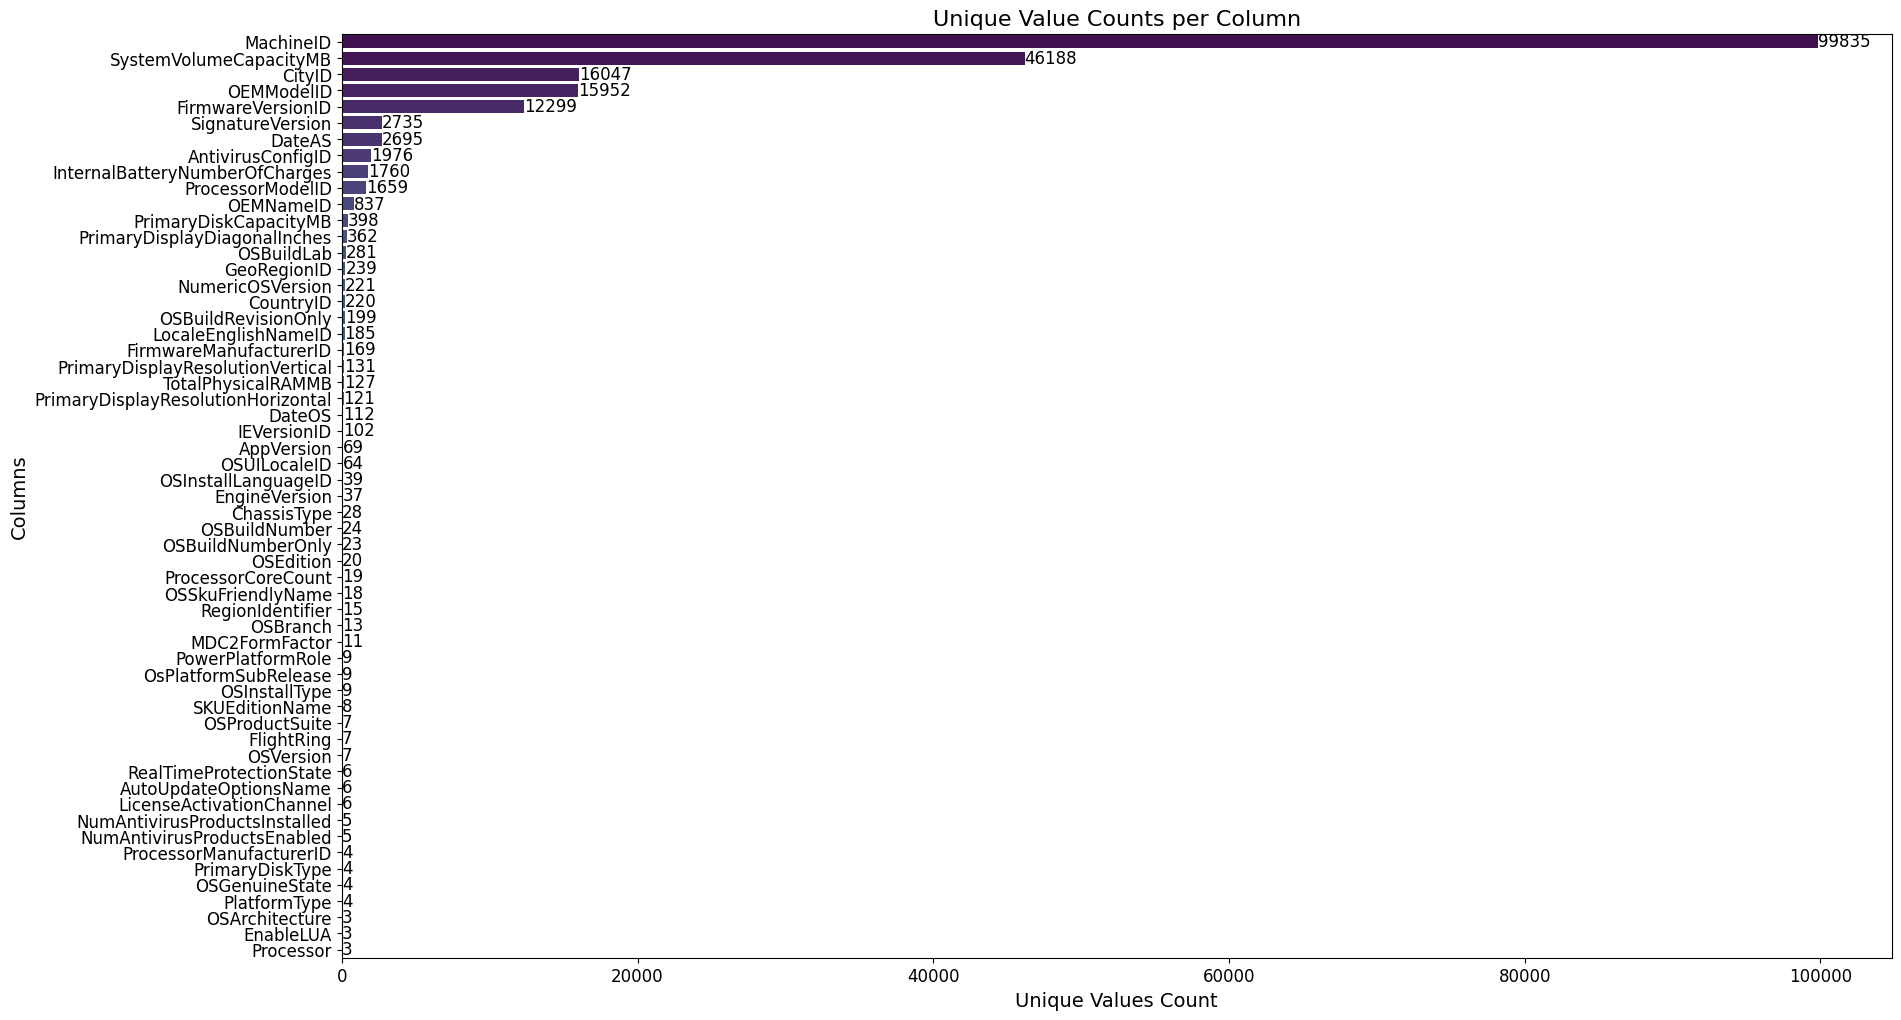

In [13]:
# Count of missing values per column
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)  # Sort in descending order

if not missing_values.empty:
    plt.figure(figsize=(20, 12))  # Increased figure size
    sns.barplot(x=missing_values.values, y=missing_values.index, palette='coolwarm')
    plt.xlabel("Missing Values Count", fontsize=14)
    plt.ylabel("Columns", fontsize=14)
    plt.title("Missing Values in Dataset", fontsize=16)
    for index, value in enumerate(missing_values.values):
        plt.text(value, index, str(value), va='center', fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

# Unique value count per column
unique_counts = df.nunique()
filtered_unique_counts = unique_counts[unique_counts >= 3].sort_values(ascending=False)  # Exclude columns with <3 unique values

plt.figure(figsize=(20, 12))  # Increased figure size
sns.barplot(x=filtered_unique_counts.values, y=filtered_unique_counts.index, palette='viridis')
plt.xlabel("Unique Values Count", fontsize=14)
plt.ylabel("Columns", fontsize=14)
plt.title("Unique Value Counts per Column", fontsize=16)
for index, value in enumerate(filtered_unique_counts.values):
    plt.text(value, index, str(value), va='center', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

## 📊 Categorical Feature Visualization  

This loop **automatically generates bar charts** for categorical columns, applying smart filtering:  
✅ **Skips columns** with **too few (<3) or too many (>11) unique values** to keep plots meaningful.  
✅ **Groups small categories** into an **"Others"** category when there are **more than 6 unique values**.  
✅ **Sorts categories** in descending order 📉 for better readability.  
✅ **Adds value labels** on bars to enhance clarity.  

This visualization helps in understanding category distribution and identifying **dominant categories**! 🚀  


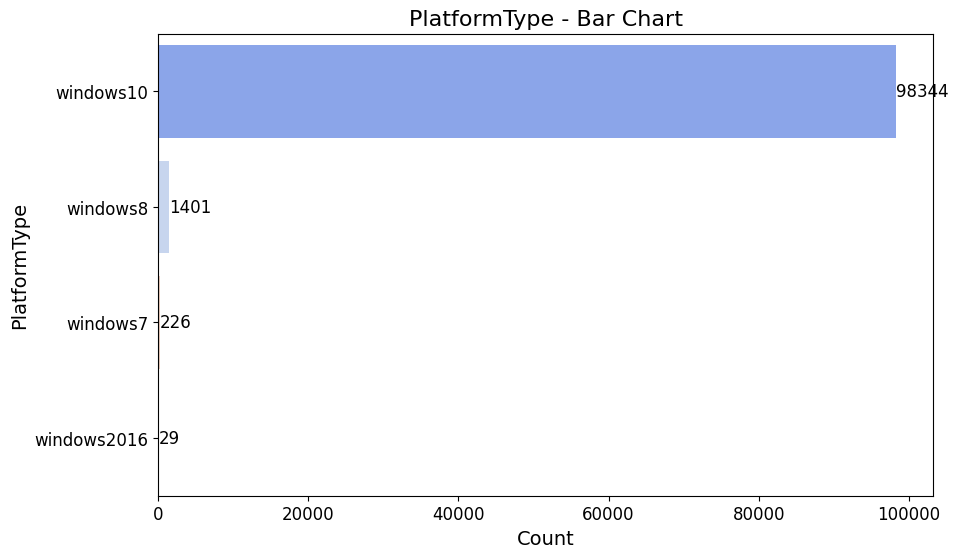

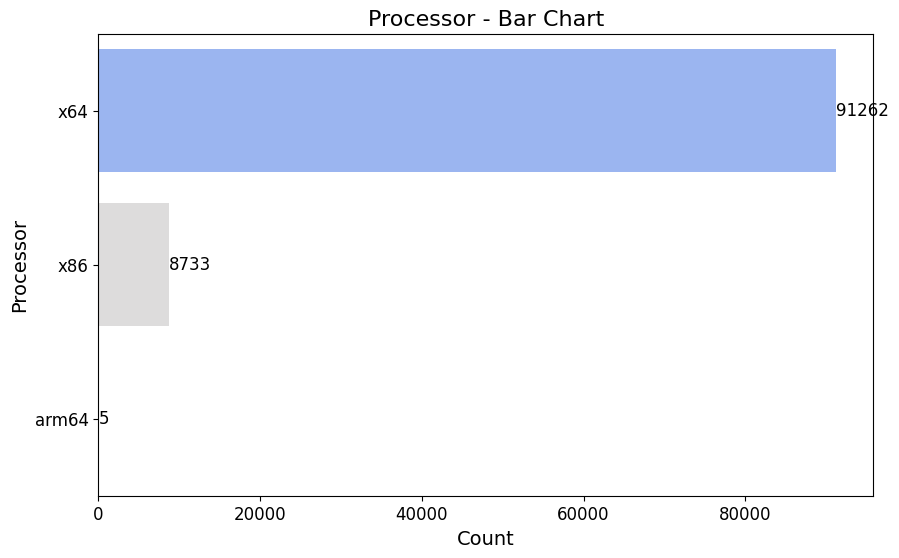

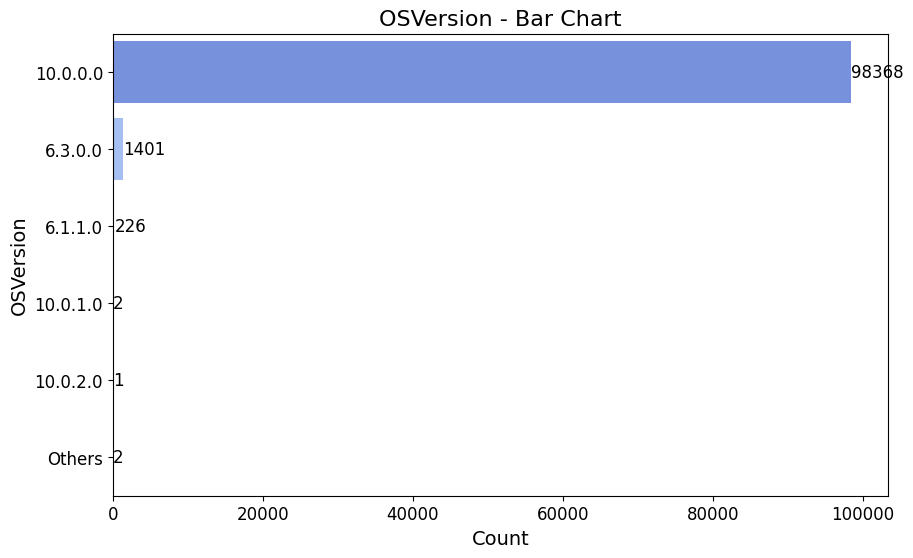

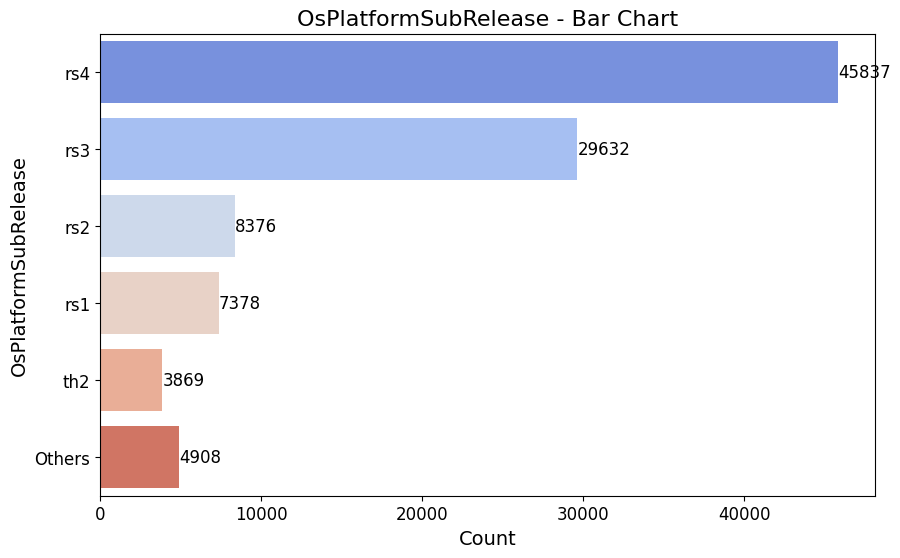

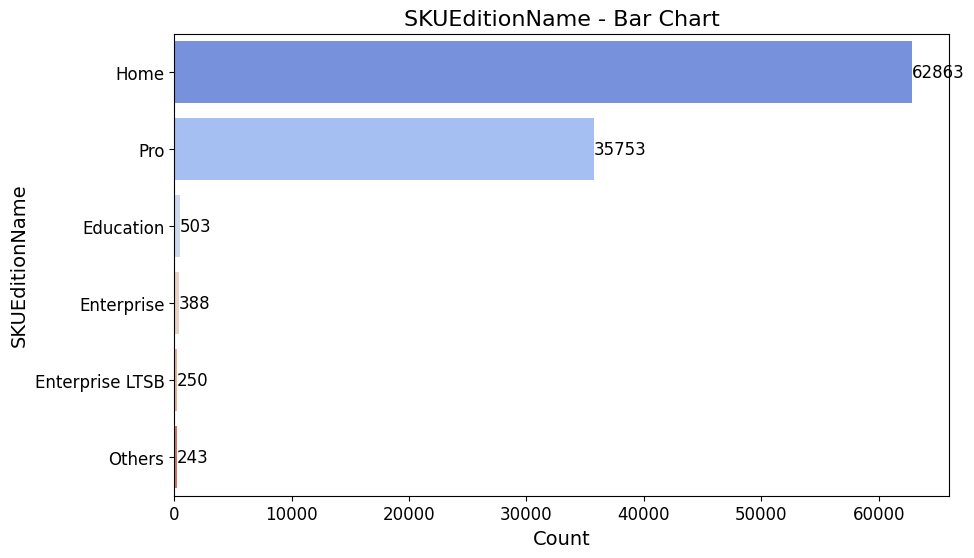

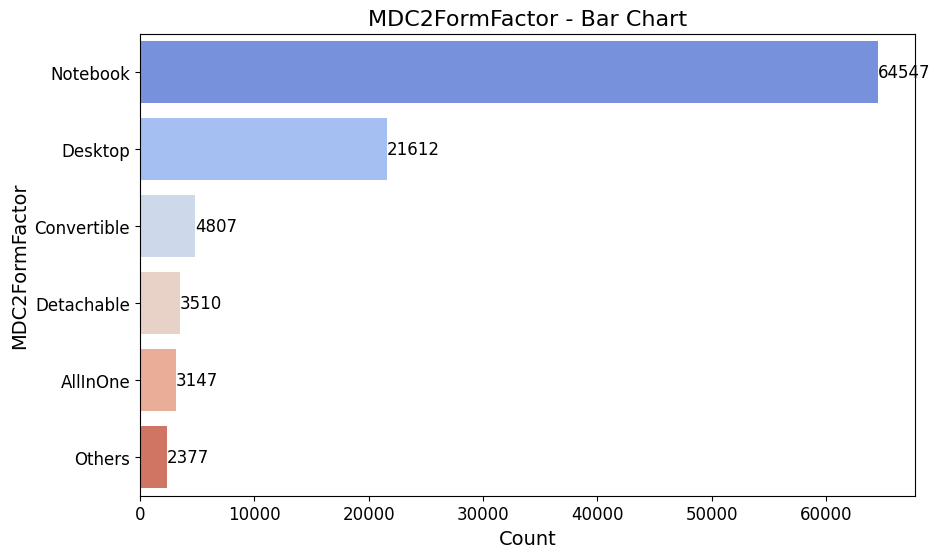

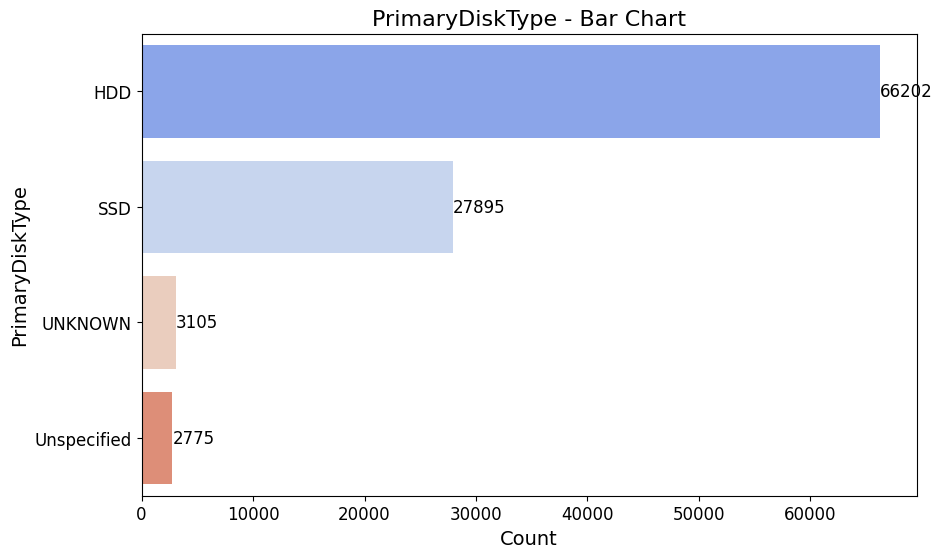

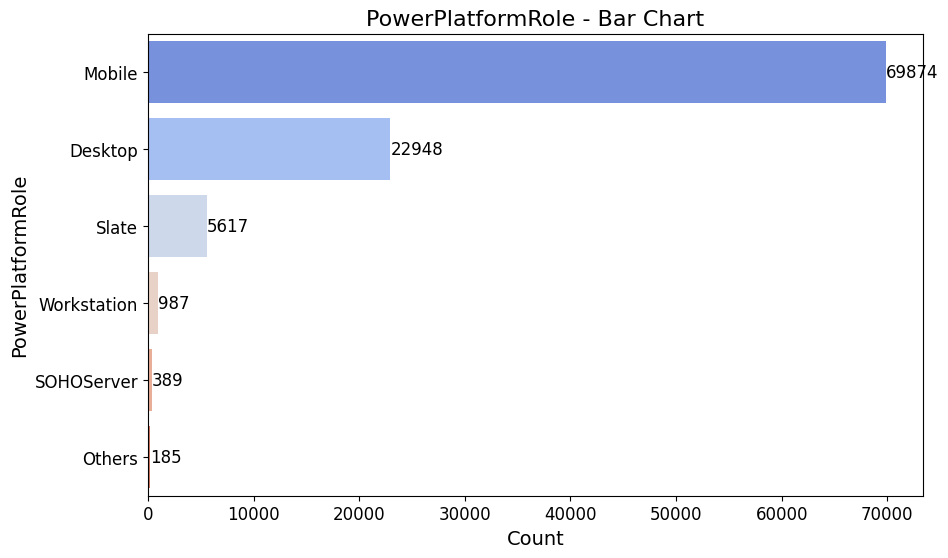

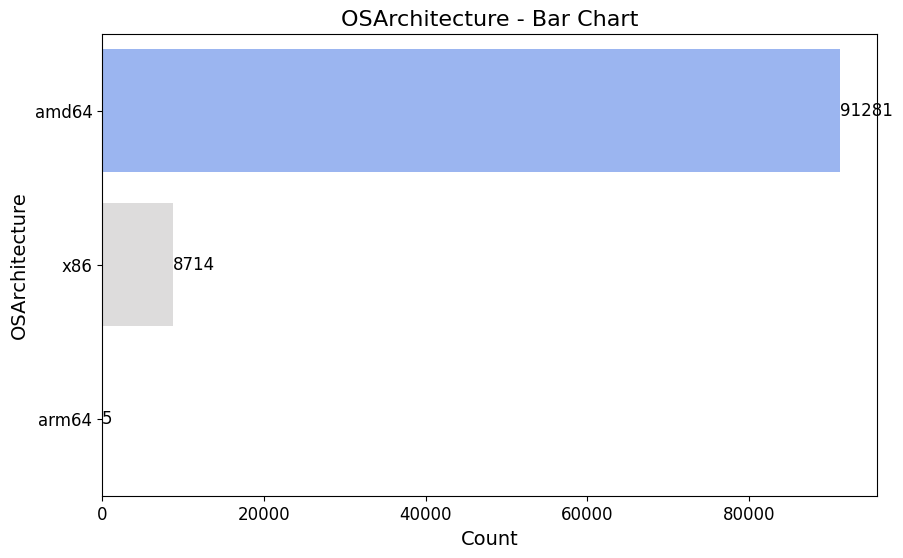

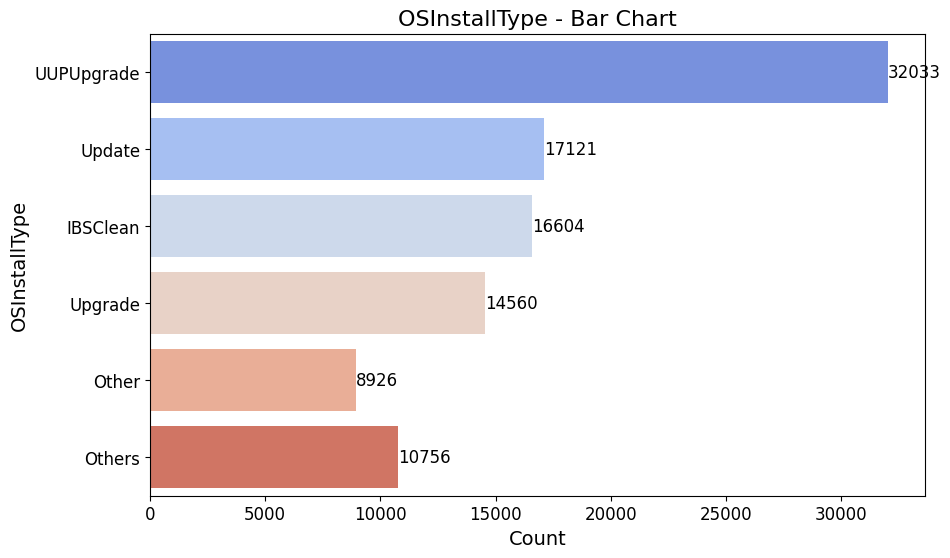

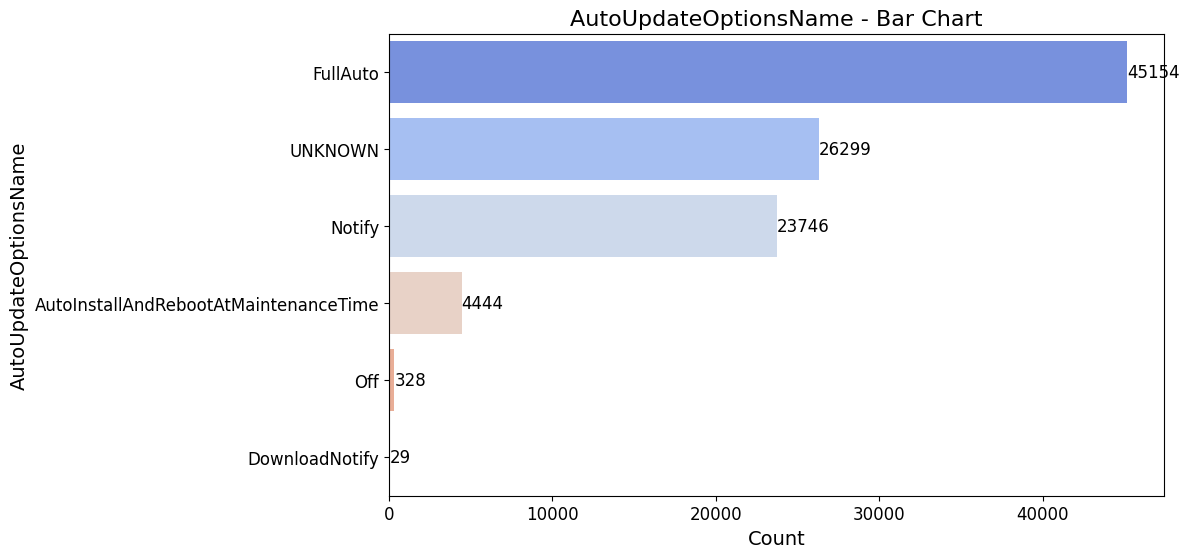

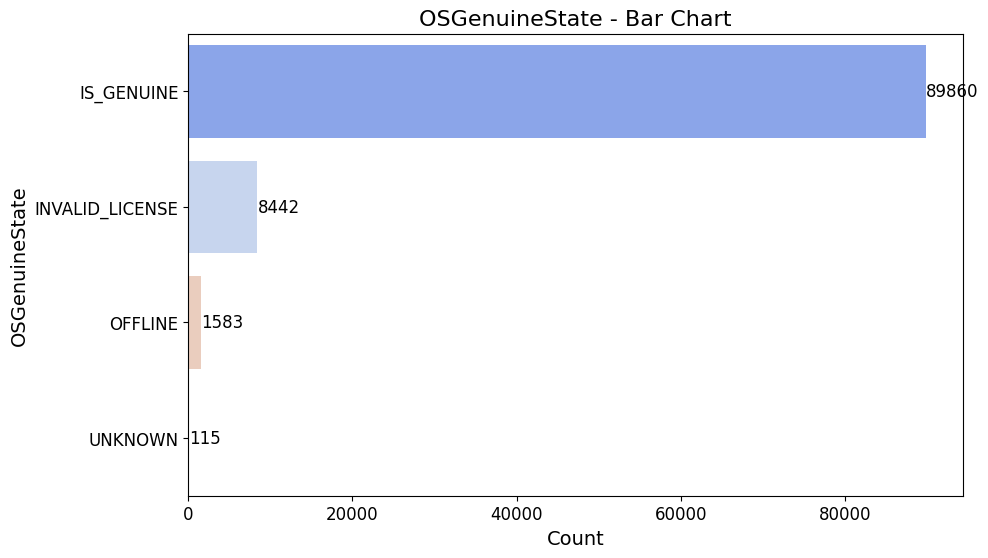

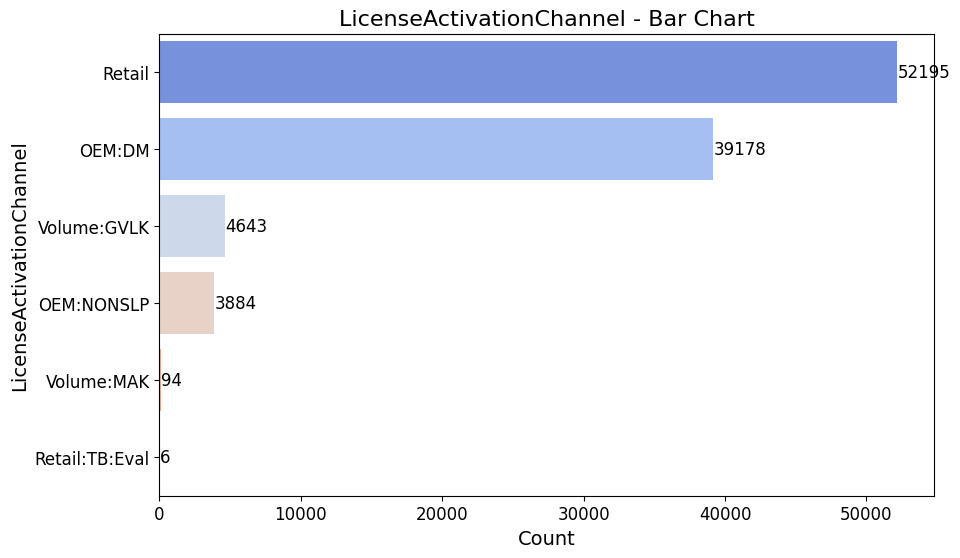

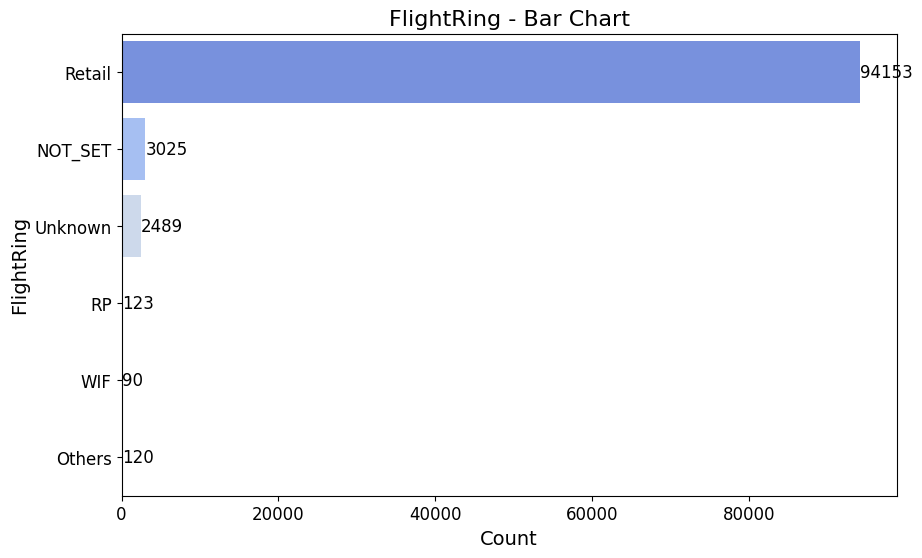

In [14]:
# Loop through categorical columns for visualization
for col in df.select_dtypes(include=['object']).columns:
    unique_count = df[col].nunique()
    if unique_count < 3 or unique_count > 11:
        continue  # Skip plotting if unique values are <3 or >11
    
    cat_counts = df[col].value_counts()
    if unique_count > 6:
        top_5 = cat_counts.nlargest(5)
        remaining_sum = cat_counts.iloc[5:].sum()
        top_5['Others'] = remaining_sum
    else:
        top_5 = cat_counts
    
    top_5 = top_5.sort_values(ascending=False)  # Sort bars in descending order
    if 'Others' in top_5:
        top_5 = pd.concat([top_5[top_5.index != 'Others'], pd.Series({'Others': top_5['Others']})])  # Keep 'Others' at the bottom
    
    plt.figure(figsize=(10, 6))  # Larger figure for clarity
    sns.barplot(x=top_5.values, y=top_5.index, palette='coolwarm')
    plt.title(f"{col} - Bar Chart", fontsize=16)
    plt.xlabel("Count", fontsize=14)
    plt.ylabel(col, fontsize=14)
    for index, value in enumerate(top_5.values):
        plt.text(value, index, str(value), va='center', fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

## 🔥 Correlation Heatmap (Filtered Columns)  

The heatmap below visualizes the correlation between numerical features in the dataset.  
- We selected only **numeric columns** with at least **2 unique values** and at most **100 unique values** to avoid excessive noise.  
- The **correlation matrix** helps in identifying relationships between features.  
- Darker red/blue shades indicate **strong positive/negative correlations**, respectively.  
- Features with high correlation may be redundant and could be considered for removal or transformation.  

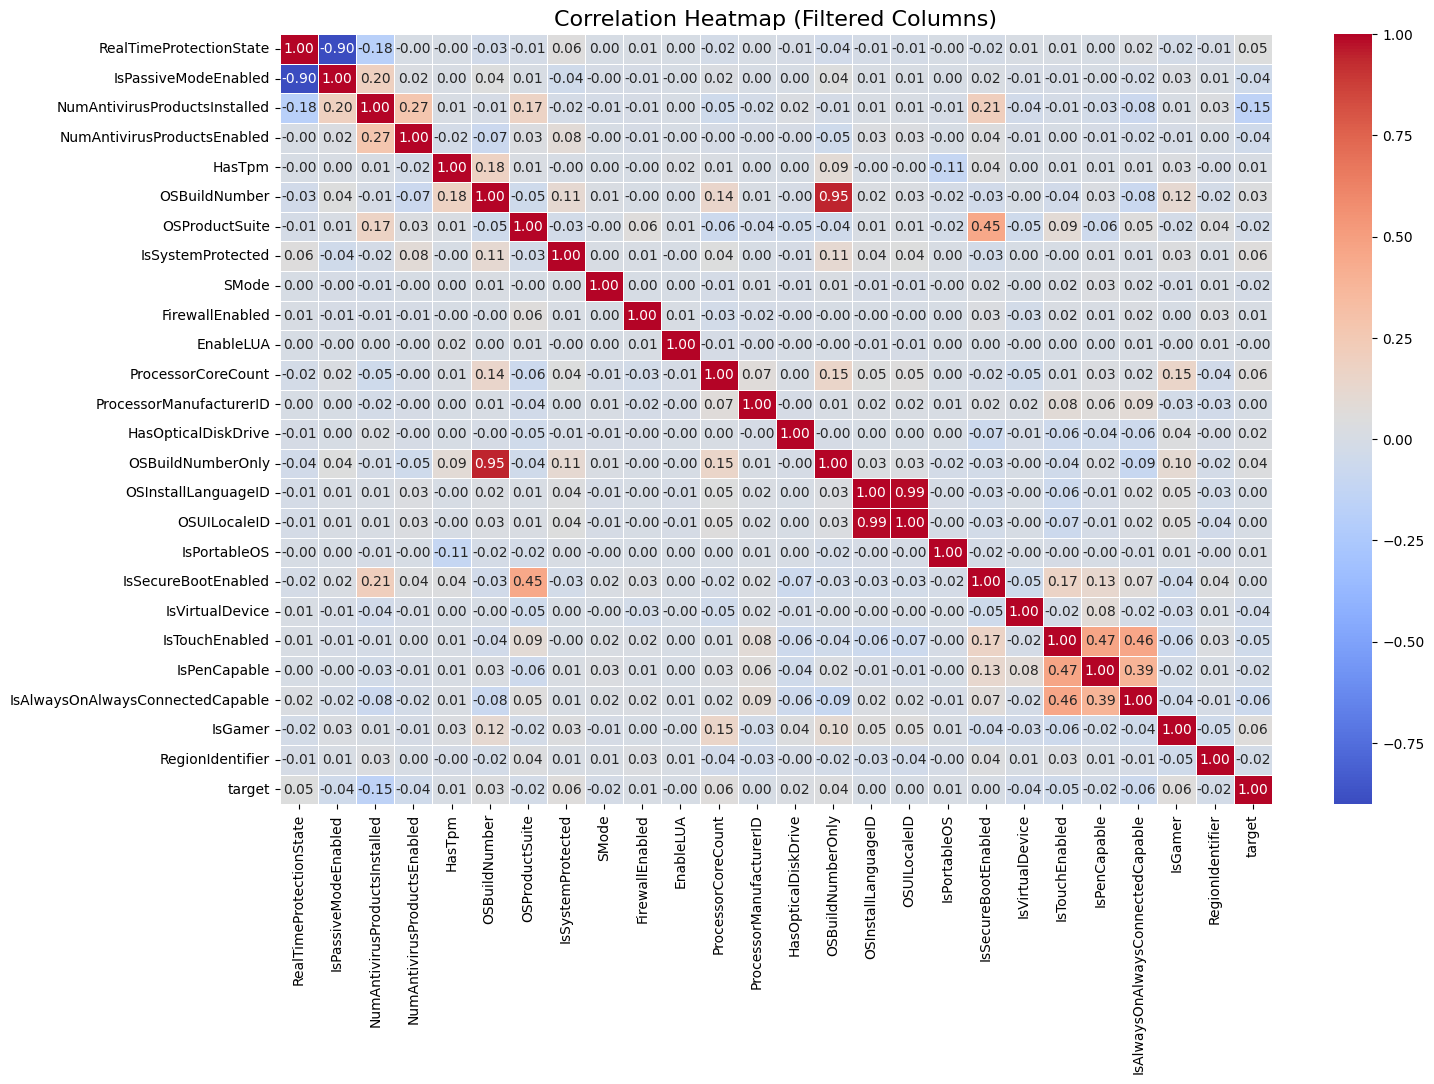

In [15]:
# Select only numerical columns
numerical_df = df.select_dtypes(include=['number'])

# Filter columns with at least 2 unique values and at most 100
valid_columns = [col for col in numerical_df.columns if 2 <= numerical_df[col].nunique() <= 100]
filtered_df = numerical_df[valid_columns]

# Compute correlation matrix
correlation_matrix = filtered_df.corr()

# Plot heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap (Filtered Columns)", fontsize=16)
plt.show()

## Droping Some not important columns

## 📌 Dropping Some Unimportant Columns  
To improve model efficiency and reduce noise, we have identified and removed specific columns based on the following criteria:  
### 🔹 **Manually Identified Columns (`man_iden`)**  
These columns have **high unique values**, making them ineffective for pattern recognition.  
### ⚠ **Columns with Imbalanced Distribution (`imbalance_dis`)**  
These columns have categories that are **highly skewed** towards one dominant value.  
### 📉 **Low-Correlation Columns (`cor_drop`)**  
These columns were removed based on **correlation analysis**, as they had minimal impact on the target variable.  
### 🛠 **Final List of Dropped Columns (`all_drop_col`)**  
The final set of removed columns is a combination of all three lists above.  

In [16]:
man_iden=['FirmwareVersionID','InternalBatteryNumberOfCharges','SystemVolumeCapacityMB','ProcessorModelID','OEMModelID','SignatureVersion','ProductName','IsFlightsDisabled','MachineID','IsBetaUser','CountryID','CityID','AutoSampleSubmissionEnabled']
imbalance_dis = ['DeviceFamily','SMode']
cor_drop = ['OSUILocaleID','OSSkuFriendlyName','OSBranch','InternalBatteryNumberOfCharges']
all_drop_col = man_iden + imbalance_dis+ cor_drop

## 📆 Splitting Date-Time Components  

### 🔹 **Purpose:**  
To extract meaningful time-based features from the `DateAS` and `DateOS` columns, converting them into separate numerical attributes for better model learning.  

### 🛠 **Transformations Applied:**  
- **For `DateAS` (Application Submission Date)**  
  - Extracts **Year, Month, Day, Hour, and Minute**  

- **For `DateOS` (Operating System Install Date)**  
  - Extracts **Year, Month, and Day**  

In [17]:
def split_datetime_components(df):
    # Convert columns to datetime
    df['DateAS'] = pd.to_datetime(df['DateAS'])
    df['DateOS'] = pd.to_datetime(df['DateOS'])
    # Split DateAS
    df['AS_Year'] = df['DateAS'].dt.year
    df['AS_Month'] = df['DateAS'].dt.month
    df['AS_Day'] = df['DateAS'].dt.day
    df['AS_Hour'] = df['DateAS'].dt.hour
    df['AS_Minute'] = df['DateAS'].dt.minute
    
    # Split DateOS
    df['OS_Year'] = df['DateOS'].dt.year
    df['OS_Month'] = df['DateOS'].dt.month
    df['OS_Day'] = df['DateOS'].dt.day
    return df

In [18]:
df = split_datetime_components(df)

In [19]:
df.drop(columns=all_drop_col+['DateOS','DateAS'],inplace=True)# Columns Drop 

In [20]:
df.head()

,EngineVersion,AppVersion,RealTimeProtectionState,IsPassiveModeEnabled,AntivirusConfigID,NumAntivirusProductsInstalled,NumAntivirusProductsEnabled,HasTpm,GeoRegionID,LocaleEnglishNameID,...,RegionIdentifier,target,AS_Year,AS_Month,AS_Day,AS_Hour,AS_Minute,OS_Year,OS_Month,OS_Day
0,1.1.15200.1,4.18.1807.18075,7.0,0,53447.0,1.0,1.0,1,98.0,103,...,6.0,0,2018,9,10,10,11,2018.0,4.0,17.0
1,1.1.15100.1,4.18.1807.18075,7.0,0,53447.0,1.0,1.0,1,167.0,227,...,10.0,1,2018,8,16,0,1,2018.0,8.0,14.0
2,1.1.15200.1,4.18.1807.18075,7.0,0,53447.0,1.0,1.0,1,98.0,103,...,6.0,1,2018,9,20,23,20,2018.0,9.0,11.0
3,1.1.15200.1,4.12.17007.18011,7.0,0,46413.0,2.0,1.0,1,276.0,74,...,12.0,1,2018,9,14,0,32,2018.0,1.0,3.0
4,1.1.15200.1,4.13.17134.228,7.0,0,40466.0,2.0,1.0,1,53.0,42,...,7.0,0,2018,9,15,19,34,2018.0,9.0,11.0


# 🛠 Data Preprocessing  

### 🔹 **Handling Missing & Invalid Values**  
In real-world datasets, missing and invalid values can distort analysis and model performance. To clean the data, we replace specific values with **NaN (Not a Number)**, making it easier to handle missing values later.  

### 🔄 **Replaced Values:**  
✔ `'?'`  
✔ `'UNKNOWN'`, `'Unknown'`, `'Unspecified'`  
✔ `'NaN'`, `'nan'`  
✔ `'Invalid'`, `'INVALID'`, `'Other'` 

In [21]:
# Replace specified values with NaN
missing_values = ['?', 'UNKNOWN', 'Unknown', 'Unspecified','NaN','nan','Invalid', 'INVALID', 'Other']
df.replace(missing_values, np.nan, inplace=True)

# ✂️ Splitting Data into Training & Testing Sets  

### 🔹 **Feature & Target Separation**  
- **`X`** → Contains all features (excluding the `target` variable).  
- **`y`** → Stores the **target variable** for prediction.  

### 🔄 **Train-Test Split**  
- **80% Training Data** 🏋️‍♂️ → Used to train the model.  
- **20% Testing Data** 🧪 → Used to evaluate model performance.  
- **Stratified Sampling (`stratify=y`)** ensures the target class distribution remains balanced in both sets.  

In [22]:
# X = df.drop('target', axis=1)  # Exclude 'target' from features
y = df['target']

# Split into Train & Test Sets
X_train, X_test, y_train, y_test = train_test_split(df.drop('target', axis=1),y, test_size=0.2, random_state=42, stratify=y)

### 📌 **Separating Numerical & Categorical Features**  
- **`num_col`** → Contains columns with **numerical values** (integers & floats).  
- **`cat_col`** → Contains **categorical columns** (object/text-based data). 

In [23]:
num_col = X_train.select_dtypes(include=['number']).columns.tolist()
cat_col = X_train.select_dtypes(include=['object']).columns.tolist()

## ⚙️ Data Preprocessing Pipeline  

### 🔹 **Numerical Feature Processing (`num_pipe`)**  
✔ **Missing Values** → Imputed using **mean strategy**.  
✔ **Scaling** → Applied **RobustScaler** to handle outliers effectively.  

### 🔹 **Categorical Feature Processing (`cat_pipe`)**  
✔ **Missing Values** → Filled using **most frequent category**.  
✔ **Encoding** → Used **One-Hot Encoding** (drops binary categories & ignores unknown categories).  

### 🔄 **ColumnTransformer (`prepro`)**  
- **Applies different transformations** to numerical & categorical columns separately.  
- **Keeps remaining columns unchanged** with `remainder="passthrough"`.  
- **Prepares the data** for model training by ensuring correct formatting. 

In [24]:
num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", RobustScaler())
])

cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop="if_binary"))
])

# Step 3: Apply transformations using ColumnTransformer
prepro = ColumnTransformer([
    ("num", num_pipe, num_col),
    ("cat", cat_pipe, cat_col)
], remainder="passthrough")  # Keep any other columns as they are
prepro

ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', RobustScaler())]),
                                 ['RealTimeProtectionState',
                                  'IsPassiveModeEnabled', 'AntivirusConfigID',
                                  'NumAntivirusProductsInstalled',
                                  'NumAntivirusProductsEnabled', 'HasTpm',
                                  'GeoRegionID', 'LocaleEnglishNameID',
                                  'OSBuildNumber', 'OSProductSuite',
                                  'IsSy...
                                                                sparse_output=False))]),
                                 ['EngineVersion', 'AppVersion', 'PlatformType',
                                  'Processor', 'OSVersion',
                                  'OsPlatformSubRelease', 'OSBuildLab',
                                  'SKUEditionName', 'MDC2FormFactor',
                                  'PrimaryDiskType', 'ChassisType',
                                  'PowerPlatformRole', 'NumericOSVersion',
                                  'OSArchitecture', 'OSEdition',
                                  'OSInstallType', 'AutoUpdateOptionsName',
                                  'OSGenuineState', 'LicenseActivationChannel',
                                  'FlightRing'])])

## ⚡ Applying Preprocessing Pipeline  

### 🔹 **Transforming Training & Testing Data**  
- **`X_train1`** → Transformed training data after applying the preprocessing pipeline.  
- **`X_test1`** → Transformed test data using the same pipeline (to maintain consistency).

In [25]:
# Apply pipeline
X_train1 = prepro.fit_transform(X_train)
X_test1 = prepro.transform(X_test)

In [26]:
# Converting X_train1 and X_test1 into DataFrame format  
X_train = pd.DataFrame(X_train1) #
X_test = pd.DataFrame(X_test1)

In [27]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,755,756,757,758,759,760,761,762,763,764
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.129213,0.759259,-8.022754,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.000000,0.0,0.0,0.0,-0.516854,0.000000,0.000000,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.483146,1.509259,1.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,-0.296296,1.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,-11.470129,1.0,0.0,0.0,0.151685,0.064815,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


# 🔥 Feature Engineering: Selecting Top Features  

### 🎯 **Feature Selection Using `SelectKBest` & Mutual Information**  
To improve model efficiency, we select the **top 100 most important features** using **Mutual Information**, which measures how much a feature contributes to predicting the target.  

### 🔹 **Steps in Feature Selection:**  
✔ **SelectKBest (`mutual_info_classif`)** → Ranks features based on their predictive power.  
✔ **Keeps the top 100 most informative features** to enhance model performance.  
✔ **Applies transformation** to both training & test sets to ensure consistency.  
✔ **Converts selected features back to a DataFrame** for better interpretability. 

In [28]:
# Apply SelectKBest to select top 100 features using Mutual Information
# selector = SelectKBest(score_func=mutual_info_classif, k=30)  
# X_train_k = selector.fit_transform(X_train, y_train)
# X_test_k = selector.transform(X_test)

# # # Get selected feature indices and names
# selected_features = selector.get_support(indices=True)
# selected_feature_names = X_train.columns[selected_features]

# # # Print the selected feature names
# # print("Selected Feature Names:", list(selected_feature_names))

# # Convert transformed arrays back to DataFrames (optional, for better readability)
# X_train_1 = pd.DataFrame(X_train_k, columns=selected_feature_names)
# X_test_1 = pd.DataFrame(X_test_k, columns=selected_feature_names)

# # Display shape of transformed datasets
# print("X_train shape after feature selection:", X_train.shape)
# print("X_test shape after feature selection:", X_test.shape)


In [29]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,755,756,757,758,759,760,761,762,763,764
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.129213,0.759259,-8.022754,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.000000,0.0,0.0,0.0,-0.516854,0.000000,0.000000,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.483146,1.509259,1.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,-0.296296,1.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,-11.470129,1.0,0.0,0.0,0.151685,0.064815,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


# Model Traning

# 🚀 Model Training & Evaluation  

### 🎯 **Training Multiple Models for Comparison**  
This step trains and evaluates multiple machine learning models to determine the **best-performing** one.  

### 🔹 **Models Used:**  
- **Logistic Regression**  
- **Gradient Boosting**  
- **Ridge Classifier**  
- **XGBoost**  
- **LightGBM**  
- **CatBoost**  

### 🔄 **Workflow:**  
1️⃣ **Train each model** on the preprocessed training dataset.  
2️⃣ **Make predictions** on the test set.  
3️⃣ **Measure accuracy** to evaluate performance.  
4️⃣ **Track execution time** to compare model efficiency.  

In [30]:
# Define models to test (including Linear Models)
models = {
    #"Logistic Regression": LogisticRegression(C=1, solver='lbfgs', max_iter=900),
    #"Gradient Boosting": GradientBoostingClassifier(learning_rate=0.1, n_estimators=100),
    #"Ridge Classifier": RidgeClassifier(alpha=10.0),
   "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", learning_rate=0.1, max_depth=5),
    "LightGBM": LGBMClassifier(learning_rate=0.1, n_estimators=100, verbose=-1),
    "CatBoost": CatBoostClassifier( depth=6, iterations=200, logging_level='Silent')
}

# Train and evaluate each model
results = {}
for name, model in models.items():
    start_time = time.time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    elapsed_time = time.time() - start_time
    results[name] = (accuracy, elapsed_time)
    #print(f"{name}: Accuracy = {accuracy:.4f}, Time = {elapsed_time:.2f}s")

# 📊 Model Performance Comparison  

### 🎯 **Ranking Models Based on Accuracy**  
After training multiple models, we compare their **accuracy and execution time** to identify the best-performing one.  

### 🔹 **How It Works?**  
✔ **Sorts models by accuracy** (highest to lowest) 📈  
✔ **Displays execution time** to evaluate efficiency ⏳  
✔ **Ranks models** to simplify selection for further tuning 🏆 

In [31]:
# Display results sorted by accuracy
sorted_results = sorted(results.items(), key=lambda item: item[1][0], reverse=True)

print("\nModel Performance Ranking:")
for rank, (name, (accuracy, elapsed_time)) in enumerate(sorted_results, start=1):
    print(f"{rank}. {name}: Accuracy = {accuracy:.4f}, Time = {elapsed_time:.2f}s")


Model Performance Ranking:
1. LightGBM: Accuracy = 0.6297, Time = 1.47s
2. XGBoost: Accuracy = 0.6254, Time = 5.72s
3. CatBoost: Accuracy = 0.6239, Time = 4.96s


Model Performance Ranking:
1. LightGBM: Accuracy = 0.6300, Time = 1.87s
2. XGBoost: Accuracy = 0.6280, Time = 8.73s
3. CatBoost: Accuracy = 0.6246, Time = 6.92s
4. Gradient Boosting: Accuracy = 0.6230, Time = 260.21s
5. Logistic Regression: Accuracy = 0.6159, Time = 46.25s
6. Ridge Classifier: Accuracy = 0.6149, Time = 2.47s

## 🏆 Model Performance Ranking (Without Feature Scaling)  

Below is the **accuracy and execution time** for different models **without feature scaling**.  

### 📊 **Model Performance Comparison**
| Rank | Model                           | Accuracy  | Time (s)  |
|------|--------------------------------|-----------|-----------|
| 🥇 1  | **LightGBM**                   | **0.6297** | 1.82  |
| 🥈 2  | **CatBoost**                   | **0.6281** | 22.03  |
| 🥉 3  | **XGBoost**                     | 0.6260    | 7.00  |
| 4    | Gradient Boosting              | 0.6224    | 241.67  |
| 5    | Random Forest                  | 0.6197    | 58.36  |
| 6    | Ridge Classifier               | 0.6149    | 2.55  |
| 7    | Logistic Regression            | 0.6147    | 42.60  |
| 8    | Stochastic Gradient Descent (SGD) | 0.6107 | 13.49  |
| 9    | K-Nearest Neighbors (KNN)      | 0.5679    | 37.42  |
| 10   | Decision Tree                  | 0.5524    | 6.69  |
| 11   | Naïve Bayes                    | 0.5222    | 1.11  |

### 🔍 **Key Observations**  
- **LightGBM performed the best** in terms of accuracy and speed ⚡.  
- **CatBoost and XGBoost showed competitive accuracy**, but CatBoost took significantly more time ⏳.  
- **Gradient Boosting & Random Forest were accurate but slow**, indicating complexity in computation.  
- **Naïve Bayes had the lowest accuracy**, suggesting it may not be suitable for this dataset.  

# 🎯 Hyperparameter Tuning  

### 🔹 **Why Tune Hyperparameters?**  
Hyperparameter tuning helps optimize model performance by selecting the best set of parameters. Instead of using default values, we define a range of options for each model and search for the most effective combination.  

### 🔄 **Models & Hyperparameters Considered**  
We tune multiple models using different sets of hyperparameters:  

- **Logistic Regression** → `C`, `solver`  
- **Gradient Boosting** → `learning_rate`, `n_estimators`  
- **Ridge Classifier** → `alpha`  
- **XGBoost** → `learning_rate`, `max_depth`  
- **LightGBM** → `learning_rate`, `n_estimators`  
- **CatBoost** → `depth`, `iterations` 

In [32]:
# Define models and hyperparameters
models = {
    # 'Logistic Regression': {
    #     'model': LogisticRegression(max_iter=1000),
    #     'params': {
    #         'C': [1, 2],  # No 'classifier__' prefix needed anymore
    #         'solver': ['lbfgs']
    #     }
    # },
    # 'Gradient Boosting': {
    #     'model': GradientBoostingClassifier(),
    #     'params': {
    #         'learning_rate': [0.01, 0.1],
    #         'n_estimators': [50, 100]
    #     }
    # },
    # 'Ridge Classifier': {
    #     'model': RidgeClassifier(),
    #     'params': {
    #         'alpha': [0.1, 1.0, 10.0]
    #     }
    # },  # Missing closing brace was here

    'XGBoost': {
        'model': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        'params': {
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 5]
        }
    },
    'LightGBM': {
        'model': LGBMClassifier(),
        'params': {
            'learning_rate': [0.01, 0.1],
            'n_estimators': [50, 100]
        }
    },
    'CatBoost': {
        'model': CatBoostClassifier(verbose=0),
        'params': {
            'depth': [3, 6],
            'iterations': [100, 200]
        }
    }
}


# 🏋️‍♂️ Model Training & Evaluation 

### 🔹 **How This Works?**  
We apply **GridSearchCV** to train and tune multiple machine learning models by:  
1️⃣ **Performing grid search** over predefined hyperparameter ranges.  
2️⃣ **Using cross-validation (`cv=5`)** to ensure stable performance.  
3️⃣ **Finding the best hyperparameter combination** for each model.  
4️⃣ **Evaluating accuracy** on the test set.   

### 🔄 **Training & Evaluation Process**  
- Each model undergoes **hyperparameter tuning** using `GridSearchCV`.  
- The best model is selected based on **highest accuracy**.  

In [33]:
# Train and evaluate models
# results = []

# for model_name, config in models.items():
#     print(f"\nTraining {model_name}...")
#     start_time = time.time()

#     # Grid search with cross-validation
#     grid = GridSearchCV(
#         config['model'],  
#         config['params'],
#         cv=5,
#         scoring='accuracy',
#         n_jobs=-1
#     )
#     grid.fit(X_train, y_train)  # Use already scaled X_train

#     # Get best model
#     best_model = grid.best_estimator_

#     # Evaluate on test set
#     y_pred = best_model.predict(X_test)  # Use already scaled X_test
#     accuracy = accuracy_score(y_test, y_pred)

#     # Store results
#     results.append({
#         'Model': model_name,
#         'Best Parameters': grid.best_params_,
#         'Accuracy': accuracy
#     })

#     end_time = time.time()
#     print(f"{model_name} trained in {end_time - start_time:.2f} seconds.")

#     # Print detailed report
#     print(f"\n=== {model_name} ===")
#     print(f"Best Parameters: {grid.best_params_}")

**Training Summary**  
Below are the training times and best hyperparameters for the top models after tuning.  

---
 **🔹 XGBoost**  
- **Training Time:** 123.63 seconds  
- **Best Parameters:** `{'learning_rate': 0.1, 'max_depth': 5}`  

---

**🔹 LightGBM**  
- **Training Time:** 38.94 seconds  
- **Best Parameters:** `{'learning_rate': 0.1, 'n_estimators': 100}`  

---

 **🔹 CatBoost**  
- **Training Time:** 102.20 seconds  
- **Best Parameters:** `{'depth': 6, 'iterations': 200}` 


In [34]:
# Compare model performances by converting results into a DataFrame
# results_df = pd.DataFrame(results)

# # Print model comparison sorted by accuracy (highest to lowest)
# print("\n=== Model Comparison ===")
# print(results_df.sort_values(by='Accuracy', ascending=False))

# # Plot accuracy comparison for different models
# plt.figure(figsize=(12, 6))  # Set figure size for better visibility
# sns.barplot(x='Accuracy', y='Model', data=results_df.sort_values(by='Accuracy', ascending=False), palette='viridis')

# # Set title and labels for better interpretation
# plt.title('Model Accuracy Comparison')
# plt.xlabel('Accuracy')
# plt.ylabel('Model')

# # Display the accuracy comparison plot
# plt.show()

# Final Model Submission

# 📌 Final Model Selection & Submission   

In [35]:
test = split_datetime_components(test) #spliting Date Columns
test.drop(columns=all_drop_col+['DateOS','DateAS'],inplace=True)

### 🔄 **Preparing the Test Data**  
- Transformed using the **preprocessing pipeline** to ensure consistency.  
- Selected features based on **feature selection methods** applied to training data.  

In [36]:
test = prepro.transform(test)

In [37]:
test=pd.DataFrame(test)

In [38]:
#m1=RandomForestClassifier(n_estimators=100, random_state=42)
#m2=CatBoostClassifier(verbose=0)
m3=LGBMClassifier(learning_rate=0.1, n_estimators=100, verbose=-1)
data = pd.concat([X_train,X_test],axis=0)
target = pd.concat([y_train,y_test],axis=0)

### 🔹 **Selecting the Best Model**  
- The model with the **highest accuracy** is chosen for final predictions.  
- The test data is **preprocessed** using the same pipeline and feature selection applied during training. 

In [39]:
# feture selection
#X_test = selector.transform(test)

# # Get selected feature indices and names
#selected_features = selector.get_support(indices=True)
#selected_feature_names = X_train.columns[selected_features]

# # Print the selected feature names
# print("Selected Feature Names:", list(selected_feature_names))

# Convert transformed arrays back to DataFrames (optional, for better readability)
#X_test = pd.DataFrame(X_test, columns=selected_feature_names)

In [40]:
m3.fit(data,target)
pred = m3.predict(test)

In [41]:
pred

array([1, 0, 1, ..., 0, 1, 0])

In [42]:
import shutil
shutil.rmtree('/kaggle/working/catboost_info', ignore_errors=True)

### 📝 **Creating Submission File**  
- Predictions are made on the **prepared test data** using the best-performing model.  
- The output is formatted according to **sample_submission.csv**.  
- A final **submission.csv** file is generated for competition submission.  

📊 *This ensures that the test predictions are properly formatted and ready for submission!*  

In [43]:
submission = pd.DataFrame(
    {'id': test.index, 'target':pred}
)

In [44]:
submission.to_csv('submission.csv',index=False)